In [1]:
# Anastassiya Ryabkova
# Project
# BS18-SE2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load data
x = np.load('x.npy')
y = np.load('y.npy')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('Train: X = %s, y = %s' % (X_train.shape, y_train.shape))
print('Test: X = %s, y = %s' % (X_test.shape, y_test.shape))

Train: X = (40000, 28, 28, 1), y = (40000,)
Test: X = (10000, 28, 28, 1), y = (10000,)


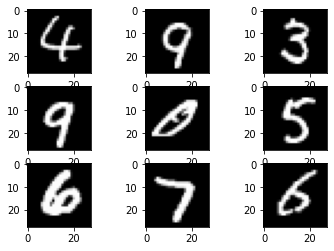

In [2]:
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i].squeeze(), cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [3]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

Train matrix shape (40000, 28, 28, 1)
Test matrix shape (10000, 28, 28, 1)


In [4]:
import tensorflow as tf

# unique classes
y_unique = np.unique(y_train, return_counts=True)


In [5]:
# define a model with layers

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters = 64, use_bias= False,  kernel_size = 5, input_shape=(28,28,1), activation='relu'))
model.add(tf.keras.layers.MaxPool2D( pool_size = 2, strides = 1)),
model.add(tf.keras.layers.Conv2D( filters = 32, use_bias= False, kernel_size = 3,  activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size = 4, strides = 2))
model.add(tf.keras.layers.Flatten( ))
model.add(tf.keras.layers.Dense(512, use_bias= False, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, use_bias= False,  activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10, use_bias= False,activation='softmax'))  



In [6]:

# def scheduler(epoch, lr):
#   if epoch == 10:
#     return lr * 0.3
#   if epoch == 20:
#     return lr * 0.5
#   return lr

# scheduler_call = tf.keras.callbacks.LearningRateScheduler(scheduler)
# define the scheduler for callback
scheduler_call = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=10)

In [7]:
# compil the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-04, clipnorm = 1),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        18432     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1327104   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [8]:
# perform data augementations
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=25, width_shift_range=0.2,
    height_shift_range=0.15, brightness_range=(0.2, 0.8), shear_range=0.2, zoom_range=0.15,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.2, horizontal_flip=False,
    vertical_flip=False, rescale=1./255, preprocessing_function=None,
    data_format=None, validation_split=0.2, dtype=None
)
datagen.fit(X_train)

# define earlystopping for callbacks
earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_accuracy", patience = 10,  
                                        restore_best_weights = True) 




In [9]:
# fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=128), epochs=35, steps_per_epoch = len(X_train)/128,
          validation_data=datagen.flow(X_train, y_train, batch_size=128, subset = 'validation'), callbacks =[earlystopping, scheduler_call])

Epoch 1/35
313/312 [==============================] - 22s 71ms/step - loss: 1.5125 - accuracy: 0.5093 - val_loss: 0.8230 - val_accuracy: 0.7715
Epoch 2/35
313/312 [==============================] - 22s 71ms/step - loss: 0.7044 - accuracy: 0.7972 - val_loss: 0.4978 - val_accuracy: 0.8669
Epoch 3/35
313/312 [==============================] - 22s 70ms/step - loss: 0.4900 - accuracy: 0.8643 - val_loss: 0.3906 - val_accuracy: 0.8951
Epoch 4/35
313/312 [==============================] - 22s 70ms/step - loss: 0.4007 - accuracy: 0.8914 - val_loss: 0.3111 - val_accuracy: 0.9161
Epoch 5/35
313/312 [==============================] - 22s 71ms/step - loss: 0.3462 - accuracy: 0.9070 - val_loss: 0.2779 - val_accuracy: 0.9243
Epoch 6/35
313/312 [==============================] - 22s 71ms/step - loss: 0.3058 - accuracy: 0.9169 - val_loss: 0.2518 - val_accuracy: 0.9333
Epoch 7/35
313/312 [==============================] - 22s 71ms/step - loss: 0.2820 - accuracy: 0.9225 - val_loss: 0.2250 - val_accuracy:

In [10]:
# evaluate the model on the test data
model.evaluate(X_test,  y_test, verbose=2)


313/313 - 1s - loss: 10.0091 - accuracy: 0.9927


[10.009051322937012, 0.9926999807357788]

In [11]:
# save the model
model.save('model.h5')